In [2]:
import pandas as pd
import numpy as np
import nltk
from HanTa import HanoverTagger as ht
import string
from tqdm.auto import tqdm
import top2vec
import pickle
import mgzip
from nltk.tokenize import sent_tokenize
from pandarallel import pandarallel

pandarallel.initialize(progress_bar=True)
tqdm.pandas()

INFO: Pandarallel will run on 8 workers.
INFO: Pandarallel will use standard multiprocessing data transfer (pipe) to transfer data between the main process and workers.


# Analysis steps for articles (topic modeling)

In [2]:
# load csv of file to process
zeit = pd.read_csv('../data/zeit_scraped.gzip', compression='gzip', low_memory=False, usecols=["title", "date", "combined_text"])
welt = pd.read_csv('../data/welt_scraped.gzip', compression='gzip', low_memory=False, usecols=["title", "date", "combined_text"])
tagesspiegel = pd.read_csv('../data/tagesspiegel_scraped.gzip', compression='gzip', low_memory=False, usecols=["title", "date", "combined_text"])

In [3]:
zeit['newspaper'] = 'zeit'
welt['newspaper'] = 'welt'
tagesspiegel['newspaper'] = 'tagespiegel'

In [4]:
combined_news = pd.concat([zeit, welt, tagesspiegel])

In [5]:
combined_news = combined_news[combined_news['combined_text'].str.contains('في')==False ]

## Tokenize, remove punctuation & lower casing
First, the original text files are loaded (note: I use gzip compression due to the big size of the files). I then get the column names of all 'comment' columns and use this to tokenize and clean all columns. The resulting tokenized & cleaned dataframe is saved with the ending '_preprocessed'.

In [7]:
combined_news['text_token'] = combined_news['combined_text'].progress_apply(nltk.word_tokenize)

  0%|          | 0/28432 [00:00<?, ?it/s]

In [8]:
punctuation_custom = list(string.punctuation)

In [9]:
punctuation_custom = punctuation_custom + ['„','“','–','•']

In [10]:
def remove_punctuation(text):
    text_list = []
    for word in text:
        for punctuation in punctuation_custom:
            word = word.replace(punctuation, '')
        if not word:
            continue
        text_list.append(word.lower())
    return text_list

In [11]:
combined_news['text_token'] = combined_news['text_token'].progress_apply(remove_punctuation)

  0%|          | 0/28432 [00:00<?, ?it/s]

## Stop word removal, lemmatization of comments & emotion lexicon
Following, stopwords without meaning ('der', 'wo', etc.) are removed from the comments. I edited the sourced stopwords list and removed any negations, since these contain emotions that I want to capture later in the workflow. Afterwards, the remaining tokenized words for each comment are lemmatized, i.e. reduced to their basic form. In order to do this I utilise the 'Hannover Tagger', which also provides part of speech information, although I do not use it (the main reason that I do not use the PoS information is that the utilised German emotion and sentiment lexical use different PoS abbreviations, resulting in no matches). The resulting output is saved as a new file with the ending '_lemma'.

In [12]:
stopwords = open('../resources/german_stopwords-master/german_stopwords_topic.txt').read().splitlines()

In [13]:
def stop_word_removal(x):
    return list([str(w) for w in x if not w in stopwords])

In [14]:
combined_news['text_token'] = combined_news['text_token'].progress_apply(stop_word_removal)

  0%|          | 0/28432 [00:00<?, ?it/s]

In [15]:
tagger = ht.HanoverTagger('morphmodel_ger.pgz')

In [16]:
def tagger_custom(input):
    tmp_list = []
    for word in input:
        tmp_list.append(tagger.analyze(word)[0].lower())
    return tmp_list

In [17]:
combined_news['text_token'] = combined_news['text_token'].parallel_apply(tagger_custom)

In [18]:
combined_news['combined_text_joined'] = combined_news['text_token'].apply(' '.join)

In [19]:
combined_news

title                 date  \
0      Handel: "Viele brauchen ja eigentlich nichts m...  2021-11-30 06:07:00   
1      DGB-Index Gute Arbeit: An den Kosten im Homeof...  2021-11-30 05:50:00   
2      Coronavirus: RKI registriert erstmals wieder l...  2021-11-30 04:23:00   
3      Bund-Länder-Runde: Kanzleramtschef fordert Cor...  2021-11-30 02:01:00   
4      Corona-Impfung für Kinder: Gesundheitsminister...  2021-11-29 19:22:00   
...                                                  ...                  ...   
12435              Virus aus Wuhan in Japan festgestellt  2020-01-16 18:17:00   
12436  Erster Todesfall durch neues, Lungenkrankheit ...  2020-01-12 11:51:00   
12437  Neues Virus ist wahrscheinlich Ursache von Lun...  2020-01-09 13:38:00   
12438                         Rätselraten über ein Virus  2020-01-07 17:24:00   
12439            Inzidenz in Berlin steigt wieder leicht  2022-03-23 08:17:00   

                                           combined_text    newspaper  \
0      ZEIT: Herr Weber, Herr Rauschen, Herr Greiner,...         zeit   
1      Wie gut sind die Arbeitsbedingungen in Deutsch...         zeit   
2      Die Zahl der Neuinfektionen pro 100.000 \nEinw...         zeit   
3      Vor der Bund-Länder-Schalte zur Corona-Krise\n...         zeit   
4      Die Gesundheitsministerinnen und -minister der...         zeit   
...                                                  ...          ...   
12435  Nach mehr als 40 Infektionen mit einem neuarti...  tagespiegel   
12436  Erstmals ist ein Patient an der geheimnisvolle...  tagespiegel   
12437  Die Ausbreitung einer zuvor unbekannten Lungen...  tagespiegel   
12438  Nachrichten aus der zentralchinesischen Provin...  tagespiegel   
12439  Die Corona-Inzidenz in Berlin ist wieder leich...  tagespiegel   

                                              text_token  \
0      [zeit, herr, weber, herr, rauschen, herr, grei...   
1      [arbeitsbedingung, deutschland, beginn, corona...   
2      [zahl, neuinfektion, 100000, einwohner, woche,...   
3      [bundländerschalte, coronakrise, pochen, gesch...   
4      [gesundheitsministerin, minister, land, corona...   
...                                                  ...   
12435  [40, infektion, neuartig, coronavirus, chinesi...   
12436  [erstmals, patient, geheimnisvoll, lungenkrank...   
12437  [ausbreitung, zuvor, unbekannt, lungenkrankhei...   
12438  [nachricht, zentralchinesisch, provinz, hubei,...   
12439  [coronainzidenz, berlin, steigen, wert, mittwo...   

                                    combined_text_joined  
0      zeit herr weber herr rauschen herr greiner wei...  
1      arbeitsbedingung deutschland beginn coronapand...  
2      zahl neuinfektion 100000 einwohner woche angab...  
3      bundländerschalte coronakrise pochen geschäfts...  
4      gesundheitsministerin minister land coronaimpf...  
...                                                  ...  
12435  40 infektion neuartig coronavirus chinesisch w...  
12436  erstmals patient geheimnisvoll lungenkrankheit...  
12437  ausbreitung zuvor unbekannt lungenkrankheit ze...  
12438  nachricht zentralchinesisch provinz hubei weck...  
12439  coronainzidenz berlin steigen wert mittwoch 10...  

[28432 rows x 6 columns]

In [ ]:
combined_news_pre = combined_news[['title', 'combined_text_joined', 'date', 'newspaper']]

In [20]:
with mgzip.open('../data/combined_news_pre.mgzip', 'wb') as handle:
    pickle.dump(combined_news, handle)

# Topic modeling
## Option 1: top2vec
Creates unique topics for each article, as feature for the comment prediction. Has to be run with speed='learn' / 'deep-learn' properly.

In [39]:
# full text, not preprocessed
docs = combined_news.combined_text.to_list()

NameError: name 'combined_news' is not defined

In [97]:
model = top2vec.Top2Vec(docs, speed="fast-learn", ngram_vocab=True, ngram_vocab_args={'min_count':50,'threshold':50.0,'connector_words':frozenset("der die das".split()),'scoring':'npmi'})

2022-06-09 14:00:33,300 - top2vec - INFO - Pre-processing documents for training
2022-06-09 14:00:53,281 - top2vec - INFO - Creating joint document/word embedding


ValueError: threshold should be between -1 and 1 for npmi scoring

In [65]:
# save model in order to save on computation time
model.save('../models/topic2vec_fastlearn_ngram.t2v')

In [15]:
model = top2vec.Top2Vec(list(test['combined_text']), speed="fast-learn")

2022-06-09 14:27:27,828 - top2vec - INFO - Pre-processing documents for training
2022-06-09 14:27:59,326 - top2vec - INFO - Creating joint document/word embedding
2022-06-09 15:01:30,446 - top2vec - INFO - Creating lower dimension embedding of documents
2022-06-09 15:02:01,141 - top2vec - INFO - Finding dense areas of documents
2022-06-09 15:02:02,592 - top2vec - INFO - Finding topics


In [16]:
# save model in order to save on computation time
model.save('../models/topic2vec_fastlearn_full.t2v')

In [34]:
# load precomputed model; args used: min_count=50, speed="fast-learn", ngram_vocab=False, workers=18, embedding_model='universal-sentence-encoder-multilingual'
model = top2vec.Top2Vec.load('../models/topic2vec_fastlearn_full.t2v')

Look at unreduced topics, found by unsupervised machine learning

In [35]:
num_of_topics = model.get_num_topics(reduced=False)

In [36]:
topic_sizes, topic_nums = model.get_topic_sizes(reduced=False)

In [37]:
topic_words, word_scores, topic_nums = model.get_topics(num_of_topics, reduced=False)

In [54]:
topic_nums, topic_score, topics_words, word_scores = model.get_documents_topics(list(combined_news_pre.index), reduced=False, num_topics=2)

In [58]:
topic_words

array([['biontech', 'moderna', 'impfstoff', ..., 'nebenwirkungen',
        'verabreichen', 'hersteller'],
       ['trump', 'trumps', 'biden', ..., 'birx', 'harris',
        'amerikanischen'],
       ['schuler', 'schulerinnen', 'unterricht', ..., 'schultrager',
        'hubig', 'prufungen'],
       ...,
       ['unserem', 'blog', 'newsblog', ..., 'deshalb', 'beschlusse',
        'es'],
       ['direktmandate', 'wahlkreise', 'wahlkreisen', ..., 'briefwahl',
        'unionsfraktion', 'parlaments'],
       ['nordkorea', 'jong', 'kim', ..., 'atomwaffen', 'russland',
        'lukaschenko']], dtype='<U15')

Reduce the models to 21, according to the percentage size of the topics

In [86]:
topic_percent = pd.DataFrame()
topic_percent['sizes'] = topic_sizes
topic_percent['percent'] = topic_percent['sizes']/sum(topic_percent['sizes'])
topic_percent['percent']

0      0.039146
1      0.026344
2      0.026273
3      0.023495
4      0.019731
         ...   
207    0.000879
208    0.000879
209    0.000774
210    0.000774
211    0.000703
Name: percent, Length: 212, dtype: float64

In [93]:
model.hierarchical_topic_reduction(7)

[[131,
  9,
  35,
  103,
  7,
  93,
  95,
  147,
  16,
  38,
  104,
  153,
  167,
  185,
  174,
  138,
  152,
  210,
  200,
  192,
  118,
  180,
  100,
  72,
  59,
  99,
  114,
  88,
  64,
  68,
  173,
  207,
  116,
  108,
  23,
  85,
  10,
  87,
  80,
  181,
  50,
  140,
  198,
  29,
  135,
  149,
  46,
  195,
  189,
  58,
  8],
 [176,
  175,
  129,
  151,
  184,
  41,
  13,
  202,
  40,
  20,
  63,
  172,
  133,
  187,
  102,
  196,
  203,
  4,
  115,
  183,
  65,
  96,
  158,
  74,
  155,
  121,
  204,
  27,
  197,
  39,
  130,
  94,
  67,
  91,
  119,
  0],
 [148,
  36,
  47,
  60,
  143,
  162,
  21,
  83,
  190,
  3,
  92,
  90,
  19,
  82,
  81,
  5,
  22,
  25,
  6,
  26,
  168,
  73,
  112,
  18],
 [127,
  141,
  34,
  128,
  188,
  105,
  208,
  75,
  137,
  106,
  54,
  123,
  111,
  2,
  160,
  70,
  98,
  178,
  134,
  201,
  209,
  79,
  61,
  170,
  101,
  166,
  211,
  109,
  182,
  62,
  169,
  86,
  78,
  164,
  179,
  159],
 [49,
  1,
  165,
  145,
  42,
  57,
  56,


In [94]:
topic_sizes, topic_nums = model.get_topic_sizes(reduced=True)
topics_words, words_scores, topics_nums = model.get_topics(reduced=True)
topic_nums, topic_score, topic_words, word_scores = model.get_documents_topics(list(test.index), reduced=True, num_topics=2)

In [96]:
topics_words

array([['bissch', 'trainer', 'lachen', 'mannschaft', 'freund', 'paar',
        'kochen', 'mal', 'freundin', 'spaß', 'spieler', 'fußball',
        'erzahlen', 'trainierenteil', 'gluck', 'torwart', 'ja', 'merken',
        'spielen', 'irgendwann', 'gucken', 'plotzlich', 'vielleicht',
        'musik', 'verbringen', 'klassenerhalt', 'gefuhl', 'gedanke',
        'borussia', 'singen', 'freundinnen', 'hakimi', 'fuhlen',
        'torhuter', 'saison', 'hertha', 'toll', 'phonsie', 'dahoud',
        'fan', 'abends', 'bundesliga', 'nett', 'lust', 'fc', 'spieltag',
        'freude', 'draußen', 'abschmecken', 'spazieren'],
       ['beschluß', 'demonstration', 'verordnung', 'spd', 'cdu',
        'coronaregeln', 'landesregierung', 'maskenpflicht', 'bundestag',
        'regelung', 'verscharfung', 'coronapolitik', 'versammlung',
        'coronamaßnahmen', 'verstoß', 'fraktion', 'grundrecht', 'csu',
        'polizei', 'fdp', 'bundesweit', 'soder', 'geltend', 'linke',
        'testpflicht', 'bundeskanzleri

Looking at wordclouds of reduced topics to find topic name, conculsion

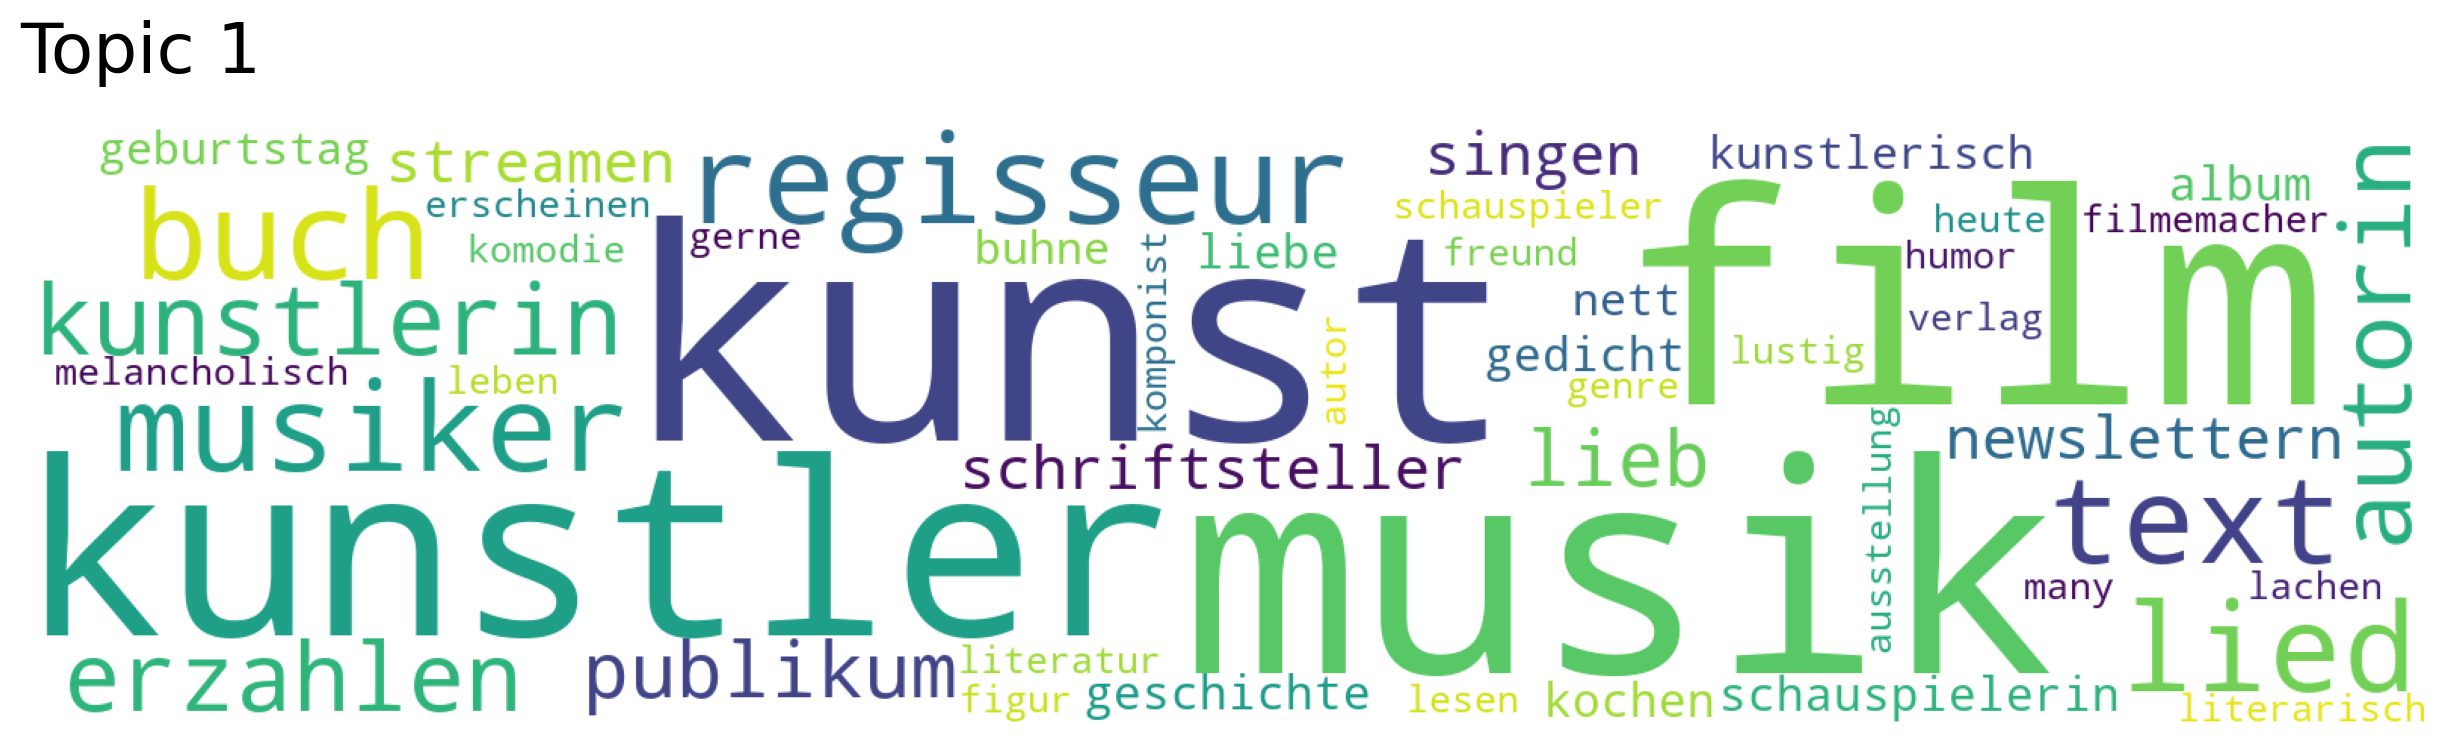

In [92]:
model.generate_topic_wordcloud(1, background_color='white', reduced=True)

In [52]:
label_dict = {0: 'Pandemiepolitik', 1: 'Regionalpolitik', 2: 'Populismus', 3: 'Infektionen', 4: 'Impfung', 5: 'Migration', 6: 'Finanzkrise'}

In [53]:
reduced_labels = model.doc_top_reduced

In [54]:
reduced_labels = np.vectorize(label_dict.get)(reduced_labels)

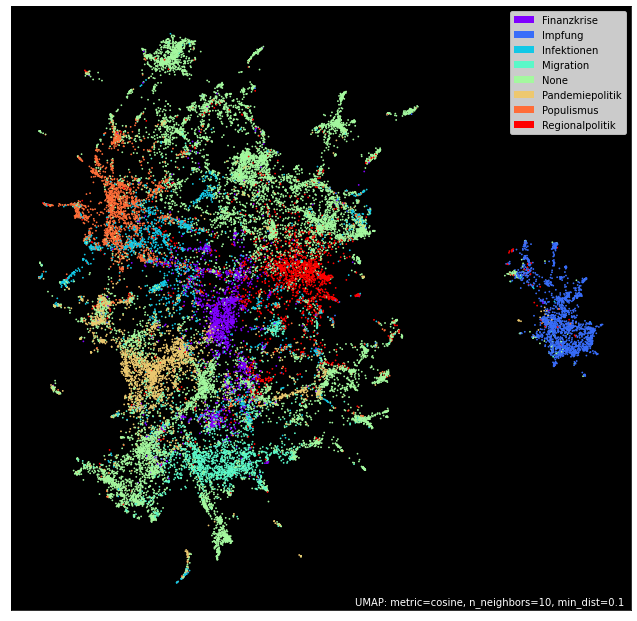

In [55]:
import umap.plot
umap_args_model = {"n_neighbors": 10, "n_components": 2, "metric": "cosine", 'min_dist':0.10, 'spread':1}
umap_model = umap.UMAP(**umap_args_model).fit(model.document_vectors)
umap_fig2 = umap.plot.points(umap_model, labels = reduced_labels, theme='fire')

## Option 2: BERTopic

In [30]:
from bertopic import BERTopic

topic_model = BERTopic(language="German", verbose=True, n_gram_range=(1,2), nr_topics='auto')

In [2]:
# preprocessed text
with mgzip.open('../data/combined_news_pre.mgzip', 'rb') as handle:
    combined_news_pre = pickle.load(handle)

In [43]:
docs = combined_news_pre.combined_text_joined.to_list()

In [33]:
topics, probs = topic_model.fit_transform(docs)

Batches:   0%|          | 0/889 [00:00<?, ?it/s]

KeyboardInterrupt: 

In [49]:
topic_model.save("../models/bert_reduced.bt")

In [5]:
topic_model = topic_model.load("../models/bert_reduced.bt")

In [7]:
topic_model.get_topic_info()

Topic  Count                                          Name
0       -1  14361                          -1__mensch_jahr_zeit
1        0   1668              0_impfstoff_impfung_impfen_dosis
2        1   1644                           1_spieler_spiel_fc_
3        2   1218                    2_app__apple_herunterladen
4        3    653  3_polizei_demonstration_demonstrant_polizist
..     ...    ...                                           ...
202    201     10   201_wirtschaft_prozent_unternehmen_institut
203    202     10     202_kosack_hossbach_schauspieler_chemnitz
204    203     10    203_gewalt_häuslich gewalt_häuslich_etzold
205    204     10          204_test_000 test_beschluß_bund land
206    205     10                205_rki_melden_zahlen_inzidenz

[207 rows x 3 columns]

In [8]:
topic_model.get_topic(0)

[('impfstoff', 0.011989519594472933),
 ('impfung', 0.007491975467219511),
 ('impfen', 0.005937364927950005),
 ('dosis', 0.005598263519381892),
 ('', 0.004796116308827525),
 ('astrazeneca', 0.004749518457124935),
 ('million', 0.004062175135322375),
 ('biontech', 0.004046582067562631),
 ('mensch', 0.003462591575239037),
 ('zulassung', 0.00304173546159226)]

In [9]:
topic_model.visualize_barchart()

In [26]:
topics = topic_model.get_topic_info()

In [27]:
topics

Topic  Count                                          Name
0       -1  14361                          -1__mensch_jahr_zeit
1        0   1668              0_impfstoff_impfung_impfen_dosis
2        1   1644                           1_spieler_spiel_fc_
3        2   1218                    2_app__apple_herunterladen
4        3    653  3_polizei_demonstration_demonstrant_polizist
..     ...    ...                                           ...
202    201     10   201_wirtschaft_prozent_unternehmen_institut
203    202     10     202_kosack_hossbach_schauspieler_chemnitz
204    203     10    203_gewalt_häuslich gewalt_häuslich_etzold
205    204     10          204_test_000 test_beschluß_bund land
206    205     10                205_rki_melden_zahlen_inzidenz

[207 rows x 3 columns]

In [28]:
new_topics, new_probs = topic_model.reduce_topics(docs, topics, nr_topics=30)

ValueError: Buffer has wrong number of dimensions (expected 1, got 2)

In [3]:
combined_news_pre

title                 date  \
0      Handel: "Viele brauchen ja eigentlich nichts m...  2021-11-30 06:07:00   
1      DGB-Index Gute Arbeit: An den Kosten im Homeof...  2021-11-30 05:50:00   
2      Coronavirus: RKI registriert erstmals wieder l...  2021-11-30 04:23:00   
3      Bund-Länder-Runde: Kanzleramtschef fordert Cor...  2021-11-30 02:01:00   
4      Corona-Impfung für Kinder: Gesundheitsminister...  2021-11-29 19:22:00   
...                                                  ...                  ...   
12435              Virus aus Wuhan in Japan festgestellt  2020-01-16 18:17:00   
12436  Erster Todesfall durch neues, Lungenkrankheit ...  2020-01-12 11:51:00   
12437  Neues Virus ist wahrscheinlich Ursache von Lun...  2020-01-09 13:38:00   
12438                         Rätselraten über ein Virus  2020-01-07 17:24:00   
12439            Inzidenz in Berlin steigt wieder leicht  2022-03-23 08:17:00   

                                           combined_text    newspaper  \
0      ZEIT: Herr Weber, Herr Rauschen, Herr Greiner,...         zeit   
1      Wie gut sind die Arbeitsbedingungen in Deutsch...         zeit   
2      Die Zahl der Neuinfektionen pro 100.000 \nEinw...         zeit   
3      Vor der Bund-Länder-Schalte zur Corona-Krise\n...         zeit   
4      Die Gesundheitsministerinnen und -minister der...         zeit   
...                                                  ...          ...   
12435  Nach mehr als 40 Infektionen mit einem neuarti...  tagespiegel   
12436  Erstmals ist ein Patient an der geheimnisvolle...  tagespiegel   
12437  Die Ausbreitung einer zuvor unbekannten Lungen...  tagespiegel   
12438  Nachrichten aus der zentralchinesischen Provin...  tagespiegel   
12439  Die Corona-Inzidenz in Berlin ist wieder leich...  tagespiegel   

                                              text_token  \
0      [zeit, herr, weber, herr, rauschen, herr, grei...   
1      [arbeitsbedingung, deutschland, beginn, corona...   
2      [zahl, neuinfektion, 100000, einwohner, woche,...   
3      [bundländerschalte, coronakrise, pochen, gesch...   
4      [gesundheitsministerin, minister, land, corona...   
...                                                  ...   
12435  [40, infektion, neuartig, coronavirus, chinesi...   
12436  [erstmals, patient, geheimnisvoll, lungenkrank...   
12437  [ausbreitung, zuvor, unbekannt, lungenkrankhei...   
12438  [nachricht, zentralchinesisch, provinz, hubei,...   
12439  [coronainzidenz, berlin, steigen, wert, mittwo...   

                                    combined_text_joined  
0      zeit herr weber herr rauschen herr greiner wei...  
1      arbeitsbedingung deutschland beginn coronapand...  
2      zahl neuinfektion 100000 einwohner woche angab...  
3      bundländerschalte coronakrise pochen geschäfts...  
4      gesundheitsministerin minister land coronaimpf...  
...                                                  ...  
12435  40 infektion neuartig coronavirus chinesisch w...  
12436  erstmals patient geheimnisvoll lungenkrankheit...  
12437  ausbreitung zuvor unbekannt lungenkrankheit ze...  
12438  nachricht zentralchinesisch provinz hubei weck...  
12439  coronainzidenz berlin steigen wert mittwoch 10...  

[28432 rows x 6 columns]

# Feature engineering

## Average sentence length

In [4]:
def avg_sent_len(input):
    sent_tokenize_list = sent_tokenize(input)
    return sum(len(x.split()) for x in sent_tokenize_list) / len(sent_tokenize_list)

In [6]:
combined_news_pre['avg_length'] = combined_news_pre['combined_text'].progress_apply(avg_sent_len)

  0%|          | 0/28432 [00:00<?, ?it/s]

## Presence of adjectives

In [ ]:
import spacy
nlp = spacy.load('en_core_web_sm')


In [8]:
tagger = ht.HanoverTagger('morphmodel_ger.pgz')

In [27]:
def pos_count(input):
    keywords_adj = ['ADJA', 'ADJD', 'ADV']
    keywords_noun = ['NN']
    count_adj = 0
    count_nn = 0
    count_total = 0
    for word in input:
        count_total += 1
        tag = tagger.analyze(word)[1]
        if tag in keywords_adj:
            count_adj += 1
        if tag in keywords_noun:
            count_nn += 1
    if count_total == 0:
        count_total = 1
    return count_adj, count_nn, count_adj/count_total, count_nn/count_total

In [29]:
combined_news_pre['pos_count'] = combined_news_pre['text_token'].parallel_apply(pos_count)

In [30]:
combined_news_pre[['count_adj', 'count_nn', 'percent_adj', 'percent_nn']] = pd.DataFrame(combined_news_pre['pos_count'].tolist(), index=combined_news_pre.index)

In [32]:
combined_news_pre.drop('pos_count', axis=1, inplace=True)

In [33]:
combined_news_pre

title                 date  \
0      Handel: "Viele brauchen ja eigentlich nichts m...  2021-11-30 06:07:00   
1      DGB-Index Gute Arbeit: An den Kosten im Homeof...  2021-11-30 05:50:00   
2      Coronavirus: RKI registriert erstmals wieder l...  2021-11-30 04:23:00   
3      Bund-Länder-Runde: Kanzleramtschef fordert Cor...  2021-11-30 02:01:00   
4      Corona-Impfung für Kinder: Gesundheitsminister...  2021-11-29 19:22:00   
...                                                  ...                  ...   
12435              Virus aus Wuhan in Japan festgestellt  2020-01-16 18:17:00   
12436  Erster Todesfall durch neues, Lungenkrankheit ...  2020-01-12 11:51:00   
12437  Neues Virus ist wahrscheinlich Ursache von Lun...  2020-01-09 13:38:00   
12438                         Rätselraten über ein Virus  2020-01-07 17:24:00   
12439            Inzidenz in Berlin steigt wieder leicht  2022-03-23 08:17:00   

                                           combined_text    newspaper  \
0      ZEIT: Herr Weber, Herr Rauschen, Herr Greiner,...         zeit   
1      Wie gut sind die Arbeitsbedingungen in Deutsch...         zeit   
2      Die Zahl der Neuinfektionen pro 100.000 \nEinw...         zeit   
3      Vor der Bund-Länder-Schalte zur Corona-Krise\n...         zeit   
4      Die Gesundheitsministerinnen und -minister der...         zeit   
...                                                  ...          ...   
12435  Nach mehr als 40 Infektionen mit einem neuarti...  tagespiegel   
12436  Erstmals ist ein Patient an der geheimnisvolle...  tagespiegel   
12437  Die Ausbreitung einer zuvor unbekannten Lungen...  tagespiegel   
12438  Nachrichten aus der zentralchinesischen Provin...  tagespiegel   
12439  Die Corona-Inzidenz in Berlin ist wieder leich...  tagespiegel   

                                              text_token  \
0      [zeit, herr, weber, herr, rauschen, herr, grei...   
1      [arbeitsbedingung, deutschland, beginn, corona...   
2      [zahl, neuinfektion, 100000, einwohner, woche,...   
3      [bundländerschalte, coronakrise, pochen, gesch...   
4      [gesundheitsministerin, minister, land, corona...   
...                                                  ...   
12435  [40, infektion, neuartig, coronavirus, chinesi...   
12436  [erstmals, patient, geheimnisvoll, lungenkrank...   
12437  [ausbreitung, zuvor, unbekannt, lungenkrankhei...   
12438  [nachricht, zentralchinesisch, provinz, hubei,...   
12439  [coronainzidenz, berlin, steigen, wert, mittwo...   

                                    combined_text_joined  avg_length  \
0      zeit herr weber herr rauschen herr greiner wei...   12.931818   
1      arbeitsbedingung deutschland beginn coronapand...   17.200000   
2      zahl neuinfektion 100000 einwohner woche angab...   14.638298   
3      bundländerschalte coronakrise pochen geschäfts...   17.703704   
4      gesundheitsministerin minister land coronaimpf...   17.000000   
...                                                  ...         ...   
12435  40 infektion neuartig coronavirus chinesisch w...   14.642857   
12436  erstmals patient geheimnisvoll lungenkrankheit...   14.413793   
12437  ausbreitung zuvor unbekannt lungenkrankheit ze...   15.769231   
12438  nachricht zentralchinesisch provinz hubei weck...   15.400000   
12439  coronainzidenz berlin steigen wert mittwoch 10...    9.560000   

       count_adj  percent_adj  count_nn  percent_nn  
0             99     0.155172       325    0.509404  
1             57     0.181529       179    0.570064  
2             62     0.181818       142    0.416422  
3             37     0.171296       118    0.546296  
4             25     0.154321        96    0.592593  
...          ...          ...       ...         ...  
12435         15     0.163043        44    0.478261  
12436         30     0.154639       111    0.572165  
12437         46     0.159170       149    0.515571  
12438         45     0.153584       154    0.525597  
12439         17     

## Mention of scientist

In [34]:
def scientist_count(input):
    keywords = ['drosten', 'streeck', 'lauterbach', 'kekulé', 'schmidt-chanasit', 'wodarg']
    scientist = []
    for word in input:
        if word in keywords:
            scientist.append(word)
    return scientist

In [36]:
df_scientists = combined_news_pre['text_token'].apply(scientist_count).str.join('|').str.get_dummies()

## Combine features into one dataframe

In [39]:
combined_news_pre = pd.concat([combined_news_pre, df_scientists], axis=1)

In [43]:
with mgzip.open('../data/combined_news_pre.mgzip', 'wb') as handle:
    pickle.dump(combined_news_pre, handle)

In [6]:
# load command
with mgzip.open('../data/combined_news_pre.mgzip', 'rb') as handle:
    combined_news_pre = pickle.load(handle)

In [7]:
# load command
with mgzip.open('../data/zeit_predict.mgzip', 'rb') as handle:
    zeit_predict = pickle.load(handle)

In [8]:
# load command
with mgzip.open('../data/tagesspiegel_predict.mgzip', 'rb') as handle:
    tagesspiegel_predict = pickle.load(handle)

In [9]:
# load command
with mgzip.open('../data/welt_predict.mgzip', 'rb') as handle:
    welt_predict = pickle.load(handle)

In [10]:
combined_predict = pd.concat([zeit_predict, tagesspiegel_predict, welt_predict])

# Construct prediction dataset

In [13]:
predict = pd.merge(combined_predict, combined_news_pre, on='title', how='inner')

In [15]:
predict

title      vote  ssentia  \
0                            Bundestag: Falsche Gewinner  negative  neutral   
1       Bundeswirtschaftsminister: Peter Altmaier wil...  negative  neutral   
2       Corona-Impfungen: "Ich war zur richtigen Zeit...  positive  neutral   
3       Corona-Lockerungen: Bayern und Hessen stellen...  negative  neutral   
4       Corona-Neuinfektionen: RKI schätzt die Lage w...  positive  neutral   
...                                                  ...       ...      ...   
24282  Über Nacht erschafft Trump in Amerika das bish...  positive  neutral   
24283  Über eine Milliarde Euro – Deutsche Bank verbu...   neutral  neutral   
24284  Übergangslager auf Lesbos fast voll – 213 Coro...  negative  neutral   
24285  Übernahmeflug von Griechenland nach Deutschlan...  negative  neutral   
24286  Überraschende Wende – Polnisches Team darf tro...  positive  neutral   

       count                 date  \
0        262  2021-10-26 11:08:00   
1        102  2020-03-08 08:54:00   
2         50  2021-04-25 18:57:00   
3         86  2021-04-27 17:51:00   
4         43  2020-12-11 12:05:00   
...      ...                  ...   
24282   1300  2020-03-21 10:58:00   
24283     10  2021-04-02 10:25:00   
24284     53  2020-09-19 14:31:00   
24285    175  2020-08-21 18:02:00   
24286      4  2020-12-29 01:23:00   

                                           combined_text newspaper  \
0      An diesem Dienstag kommt der neue Bundestag er...      zeit   
1      BundeswirtschaftsministerPeter Altmaier\nwill ...      zeit   
2      Ein Aufklärungsgespräch, der Stich in den Ober...      zeit   
3      Vollständig Geimpfte werden in Bayern ab Mittw...      zeit   
4      Die Corona-Lage in Deutschland ist nach Einsch...      zeit   
...                                                  ...       ...   
24282  Es ist eines der größten Hilfspakete in der am...      welt   
24283  Nach fünf Verlustjahren in Folge hat die Deuts...      welt   
24284  Das nach dem Brand im Flüchtlingslager Moria e...      welt   
24285  Die Corona- und die Flüchtlingskrise, sie ware...      welt   
24286  Sie dürfen springen, sie dürfen nicht. Sie dür...      welt   

                                              text_token  \
0      [dienstag, bundestag, erstmals, politikwissens...   
1      [bundeswirtschaftsministerpeter, altmaier, cor...   
2      [aufklärungsgespräch, stich, oberarm, stempel,...   
3      [geimpft, bayern, mittwoch, negativ, corona, g...   
4      [coronalage, deutschland, einschätzung, robert...   
...                                                  ...   
24282  [groß, hilfspaket, amerikanisch, geschichte, p...   
24283  [verlustjahr, folge, deutsch, bank, jahr, coro...   
24284  [brand, flüchtlingslager, moria, errichtet, üb...   
24285  [corona, flüchtlingskrise, voneinander, trenne...   
24286  [springen, springen, coronachaos, polnisch, sk...   

                                    combined_text_joined  avg_length  \
0      dienstag bundestag erstmals politikwissenschaf...   17.465909   
1      bundeswirtschaftsministerpeter altmaier corona...   22.375000   
2      aufklärungsgespräch stich oberarm stempel durc...   18.280000   
3      geimpft bayern mittwoch negativ corona geteste...   13.900000   
4      coronalage deutschland einschätzung robert koc...   13.333333   
...                                                  ...         ...   
24282  groß hilfspaket amerikanisch geschichte präsid...   16.066667   
24283  verlustjahr folge deutsch bank jahr coronakris...   20.303030   
24284  brand flüchtlingslager moria errichtet übergan...   16.625000   
24285  corona flüchtlingskrise voneinander trennen me...   17.307692   
24286  springen springen coronachaos polnisch skispri...   14.866667   

       count_adj  percent_adj  count_nn  percent_nn  drosten  kekulé  \
0            102     0.161648       347    0.549921        0       0   
1             26     0.174497        93    0.624161        0       0   
2             

In [20]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import TimeSeriesSplit, GridSearchCV
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split

In [16]:
X = predict[['count', 'newspaper', 'avg_length', 'count_adj', 'percent_adj', 'count_nn', 'percent_nn', 'drosten', 'kekulé', 'lauterbach', 'streeck', 'wodarg']]

In [26]:
X = pd.get_dummies(X)

In [27]:
y = predict['vote']

In [28]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

In [ ]:
# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 10, stop = 1000, num = 10)]
# Criterion
criterion =['gini', 'entropy']
# Number of features to consider at every split
max_features = ['log2', 'sqrt', 'auto']
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(1, 100, num = 10)]
max_depth.append(None)
# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4]
# Method of selecting samples for training each tree
bootstrap = [True, False]
# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'criterion': criterion,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf}

# Use the random grid to search for best hyperparameters
# First create the base model to tune
rf = RandomForestClassifier()
# Random search of parameters, using 3 fold cross validation,
# search across 100 different combinations, and use all available cores
rf_random = RandomizedSearchCV(estimator = rf, param_distributions = random_grid, n_iter = 15 , cv = 5, verbose = 3, random_state=42, n_jobs = -1)
# Fit the random search model
rf_random.fit(X_train,y_train)

rf_random.best_params_

Fitting 5 folds for each of 15 candidates, totalling 75 fits


In [29]:
regr = RandomForestClassifier(verbose=1, n_jobs=-1)
#regr = RandomForestClassifier(verbose = 1, n_jobs = -1, n_estimators = 670, min_samples_split = 2, min_samples_leaf = 1, max_features = 'sqrt', max_depth = 89, criterion = 'entropy')
regr.fit(X_train, y_train)
regr.score(X_test, y_test)

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    0.5s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.1s finished


0.6179663131628197